In [66]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
%matplotlib inline
from finrl.config_tickers import SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from settings import *
from pprint import pprint
import sys
import os
import itertools
import json

if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

sys.path.append("../FinRL-Library")


In [67]:
INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30']

with open("data/stock.json") as f:
    list_tickers = list(json.load(f).keys())

In [68]:

if not os.path.exists("data/full_data.csv"):
    df = YahooDownloader(start_date = TRAIN_START_DATE,
                         end_date = TEST_END_DATE,
                         ticker_list = list_tickers).fetch_data()
    df.to_csv()
else:
    df = pd.read_csv("data/full_data.csv", index_col=0)
df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (251700, 8)


,date,open,high,low,close,volume,tic,day
0,2002-01-02,14.220000,14.230000,13.750000,8.560054,1247400,ADM,2
1,2002-01-02,1589.000000,1589.000000,1556.199951,967.096680,301855,AIG,2
2,2002-01-02,47.349998,47.400002,46.849998,19.867025,184400,AVB,2
3,2002-01-02,38.540001,38.669998,37.849998,25.237371,3545800,BA,2
4,2002-01-02,31.250000,31.375000,29.900000,30.900000,62600,BIO,2


In [69]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

if os.path.exists("data/df_processed.csv"):
    fe = FeatureEngineer(use_technical_indicator=True,
                         tech_indicator_list = INDICATORS,
                         use_turbulence=True,
                         user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    processed.to_csv("df_processed.csv")
else:
    processed = pd.read_csv("df_processed.csv")

In [70]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 50, State Space: 301


In [71]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [72]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

In [73]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [74]:
df_trade_date = pd.DataFrame({'data':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, pd.DataFrame(temp)], ignore_index=True)
    # df_account_value = df_account_value.append(temp,ignore_index=True)
    
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True)) # ensemble method
df_account_value_a2c = pd.read_csv("results_rl/df_account_value_a2c.csv") # a2c method

df_account_value_a2c = df_account_value_a2c[df_account_value_a2c["date"] <= df_account_value["date"].values[-1]]

sharpe_ensemble=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio (Ensemble) : ',sharpe_ensemble)

sharpe_a2c=(252**0.5)*df_account_value_a2c.account_value.pct_change(1).mean()/df_account_value_a2c.account_value.pct_change(1).std()
print('Sharpe Ratio (A2C) : ',sharpe_a2c)


Sharpe Ratio (Ensemble) :  0.9253008389797331
Sharpe Ratio (A2C) :  0.8501302998850069


In [75]:
df_account_value.head()

,account_value,date,daily_return,data
0,1.000000e+06,2018-04-04,NaN,2018-04-04
1,1.000523e+06,2018-04-05,0.000523,2018-04-05
2,9.877022e+05,2018-04-06,-0.012814,2018-04-06
3,9.876415e+05,2018-04-09,-0.000062,2018-04-09
4,1.005869e+06,2018-04-10,0.018456,2018-04-10


In [76]:
df_account_value_a2c.head()

,Unnamed: 0,date,account_value
0,0,2018-01-02,1.000000e+06
1,1,2018-01-03,1.001235e+06
2,2,2018-01-04,1.001629e+06
3,3,2018-01-05,1.003857e+06
4,4,2018-01-08,1.003401e+06


In [77]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.173274
Cumulative returns     0.749435
Annual volatility      0.193187
Sharpe ratio           0.925301
Calmar ratio           0.735675
Stability              0.761172
Max drawdown          -0.235530
Omega ratio            1.185167
Sortino ratio          1.309208
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.028872
Daily value at risk   -0.023630
dtype: float64


In [78]:
#baseline stats
print("==============Get Baseline Stats===========")
df_gspc_ = get_baseline(
        ticker="^GSPC",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_gspc_, value_col_name = 'close')

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (881, 8)
Annual return          0.149737
Cumulative returns     0.628750
Annual volatility      0.217585
Sharpe ratio           0.751647
Calmar ratio           0.441378
Stability              0.782700
Max drawdown          -0.339250
Omega ratio            1.170487
Sortino ratio          1.037755
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.811005
Daily value at risk   -0.026764
dtype: float64


In [79]:
df_gspc = pd.DataFrame()
df_gspc['date'] = df_account_value['date']
df_gspc['gspc'] = df_gspc_['close'] / df_gspc_['close'][0] * env_kwargs["initial_amount"]
df_gspc.to_csv("df_gspc.csv")
df_gspc = df_gspc.set_index(df_gspc.columns[0])
df_gspc

,gspc
date,
2018-04-04,1.000000e+06
2018-04-05,1.006863e+06
2018-04-06,9.847922e+05
2018-04-09,9.880780e+05
2018-04-10,1.004606e+06
...,...
2021-09-27,1.680012e+06
2021-09-28,1.645800e+06
2021-09-29,1.648382e+06


In [80]:
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')
df_result_a2c = pd.DataFrame({'date': df_account_value_a2c['date'], 'a2c': df_account_value_a2c['account_value']})
df_result_a2c = df_result_a2c.set_index('date')

df_result_ensemble

,ensemble
date,
2018-04-04,1.000000e+06
2018-04-05,1.000523e+06
2018-04-06,9.877022e+05
2018-04-09,9.876415e+05
2018-04-10,1.005869e+06
...,...
2021-09-27,1.802571e+06
2021-09-28,1.754909e+06
2021-09-29,1.760246e+06


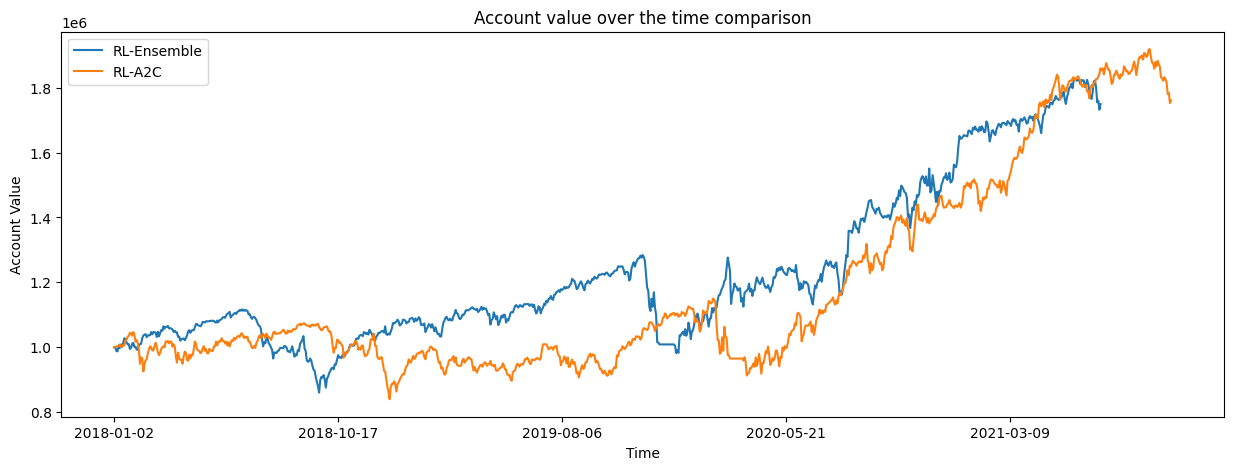

In [91]:
# Plot the account values
df_result_ensemble.ensemble.plot(label='RL-Ensemble')
df_result_a2c.a2c.plot(label='RL-A2C')

# Add title and labels
plt.title('Account value over the time comparison')
plt.xlabel('Time')
plt.ylabel('Account Value')

# Add legend
plt.legend()

# Show the plot
plt.show()

[*********************100%%**********************]  1 of 1 completed

==============Compare to GSPC===========
Shape of DataFrame:  (756, 8)


Start date,2018-04-04
End date,2021-10-01
Total months,42
,Backtest
Annual return,17.3%
Cumulative returns,74.9%
Annual volatility,19.3%
Sharpe ratio,0.93
Calmar ratio,0.74
Stability,0.76
Max drawdown,-23.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.55,2020-02-19,2020-04-01,2020-11-05,187
1,22.97,2018-09-14,2018-12-24,2019-07-10,214
2,8.72,2021-01-19,2021-01-29,2021-02-11,18
3,7.34,2021-02-24,2021-03-08,2021-03-26,23
4,5.19,2021-08-31,2021-09-30,NaT,NaN


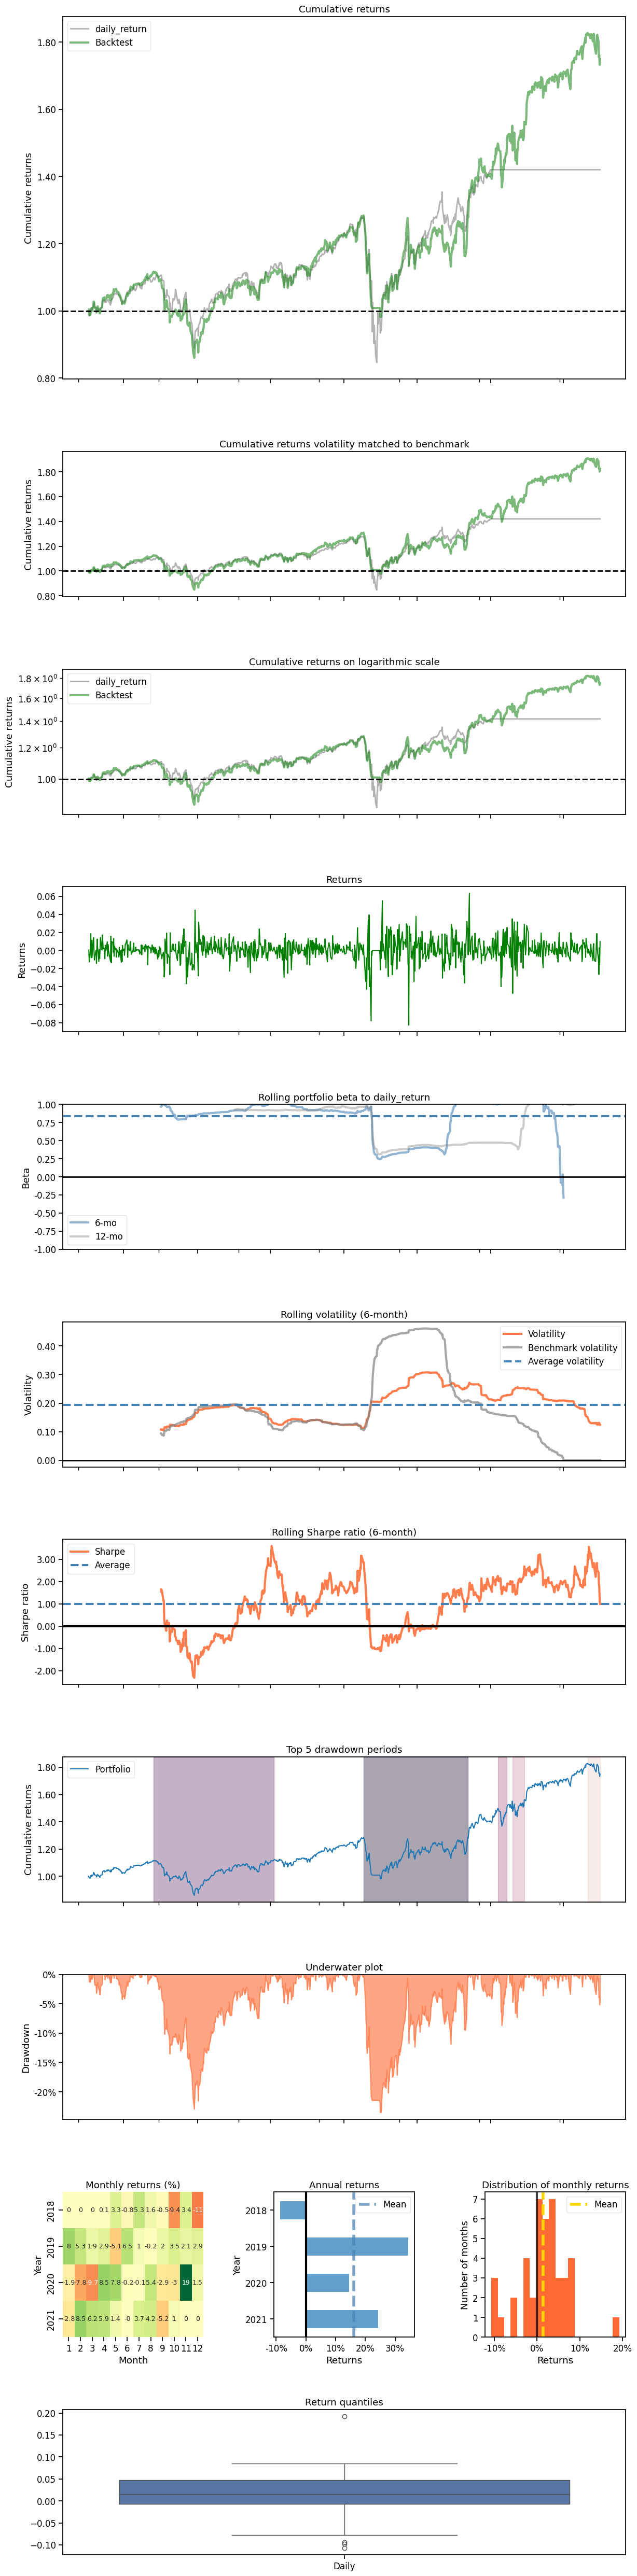

In [82]:
print("==============Compare to GSPC===========")
%matplotlib inline
backtest_plot(df_account_value, 
             baseline_ticker = '^GSPC', 
             baseline_start = '2018-01-01',
             baseline_end = '2021-01-01')

==============Compare to GSPC===========


<Figure size 1500x500 with 0 Axes>

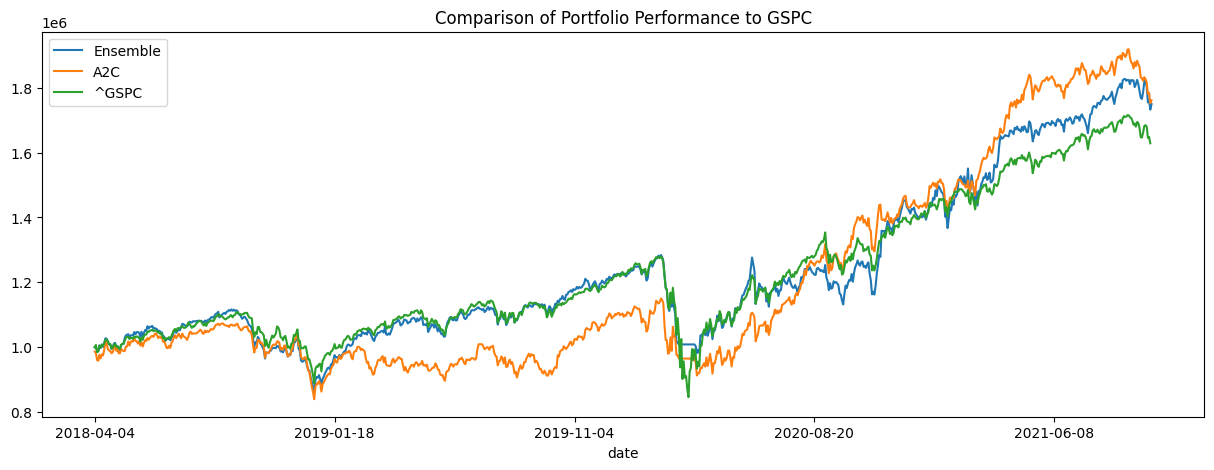

In [104]:
print("==============Compare to GSPC===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)
result = pd.merge(df_result_ensemble, df_result_a2c, left_index=True, right_index=True)
result = pd.merge(result, df_gspc, left_index=True, right_index=True)

# result.to_csv("result.csv")
result.columns = ['Ensemble', 'A2C', '^GSPC']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.title("Comparison of Portfolio Performance to GSPC")
plt.show()


## Compare with MVO

In [141]:
df_10_mvo = pd.read_csv("results_mvo/10-mvo_analysis.csv")
df_10_mvo = df_10_mvo[(df_10_mvo["Date"] >= df_result_ensemble.index[0]) & (df_10_mvo["Date"] <= df_result_ensemble.index[-1])]
df_10_mvo.set_index('Date', inplace=True)
# df_10_mvo = df_10_mvo / df_10_mvo["port_value"][0]
df_10_mvo = df_10_mvo[["port_value"]]*1e6


df_20_mvo = pd.read_csv("results_mvo/20-mvo_analysis.csv")
df_20_mvo = df_20_mvo[(df_20_mvo["Date"] >= df_result_ensemble.index[0]) & (df_20_mvo["Date"] <= df_result_ensemble.index[-1])]
df_20_mvo.set_index('Date', inplace=True)
# df_20_mvo = df_20_mvo / df_20_mvo["port_value"][0]
df_20_mvo = df_20_mvo[["port_value"]]*1e6

df_30_mvo = pd.read_csv("results_mvo/30-mvo_analysis.csv")
df_30_mvo = df_30_mvo[(df_30_mvo["Date"] >= df_result_ensemble.index[0]) & (df_30_mvo["Date"] <= df_result_ensemble.index[-1])]
df_30_mvo.set_index('Date', inplace=True)
# df_30_mvo = df_30_mvo / df_30_mvo["port_value"][0]
df_30_mvo = df_30_mvo[["port_value"]]*1e6


df_5_mvo = pd.read_csv("results_mvo/5-mvo_analysis.csv")
df_5_mvo = df_5_mvo[(df_5_mvo["Date"] >= df_result_ensemble.index[0]) & (df_5_mvo["Date"] <= df_result_ensemble.index[-1])]
df_5_mvo.set_index('Date', inplace=True)
# df_5_mvo = df_5_mvo / df_5_mvo["port_value"][0]
df_5_mvo = df_5_mvo[["port_value"]]*1e6


==============Compare to MVO===========


<Figure size 1500x500 with 0 Axes>

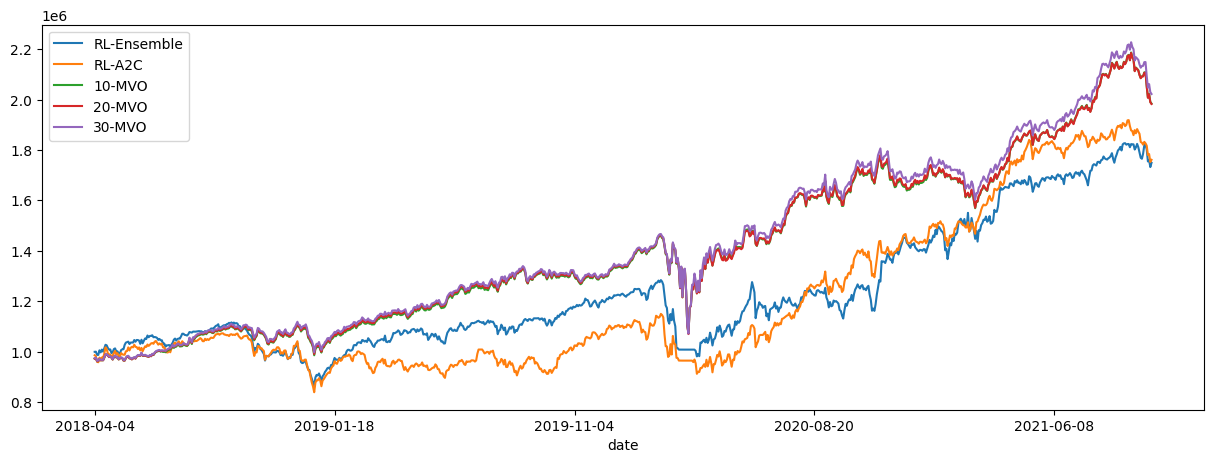

In [85]:
print("==============Compare to MVO===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_result_a2c, left_index=True, right_index=True)
result = pd.merge(result, df_10_mvo, left_index=True, right_index=True)
result = pd.merge(result, df_20_mvo, left_index=True, right_index=True)
result = pd.merge(result, df_30_mvo, left_index=True, right_index=True)
result.columns = ['RL-Ensemble', 'RL-A2C',  '10-MVO', '20-MVO', '30-MVO']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();
plt.savefig("RL-MVO.png")

### Backtest plot MVO

In [157]:
df_10_mvo = pd.read_csv("results_mvo/10-mvo_analysis.csv")
df_10_mvo = df_10_mvo[(df_10_mvo["Date"] >= df_result_ensemble.index[0]) & (df_10_mvo["Date"] <= df_result_ensemble.index[-1])]
df_10_mvo["port_value"] = df_10_mvo["port_value"]*1e6
df_10_mvo = df_10_mvo.rename(columns={'Date':'date', "port_value" : "account_value"})

df_20_mvo = pd.read_csv("results_mvo/20-mvo_analysis.csv")
df_20_mvo = df_20_mvo[(df_20_mvo["Date"] >= df_result_ensemble.index[0]) & (df_20_mvo["Date"] <= df_result_ensemble.index[-1])]
df_20_mvo["port_value"] = df_20_mvo["port_value"]*1e6
df_20_mvo = df_20_mvo.rename(columns={'Date':'date', "port_value" : "account_value"})

df_30_mvo = pd.read_csv("results_mvo/30-mvo_analysis.csv")
df_30_mvo = df_30_mvo[(df_30_mvo["Date"] >= df_result_ensemble.index[0]) & (df_30_mvo["Date"] <= df_result_ensemble.index[-1])]
df_30_mvo["port_value"] = df_30_mvo["port_value"]*1e6
df_30_mvo = df_30_mvo.rename(columns={'Date':'date', "port_value" : "account_value"})


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (21, 8)


Start date,2018-04-04
End date,2021-10-01
Total months,42
,Backtest
Annual return,22.6%
Cumulative returns,104.0%
Annual volatility,19.1%
Sharpe ratio,1.17
Calmar ratio,0.85
Stability,0.96
Max drawdown,-26.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.47,2020-02-19,2020-03-23,2020-05-29,73
1,11.63,2020-11-06,2021-03-04,2021-04-15,115
2,11.08,2018-12-03,2018-12-24,2019-02-21,59
3,9.26,2021-09-08,2021-10-01,NaT,NaN
4,6.70,2018-09-14,2018-10-29,2018-12-03,57


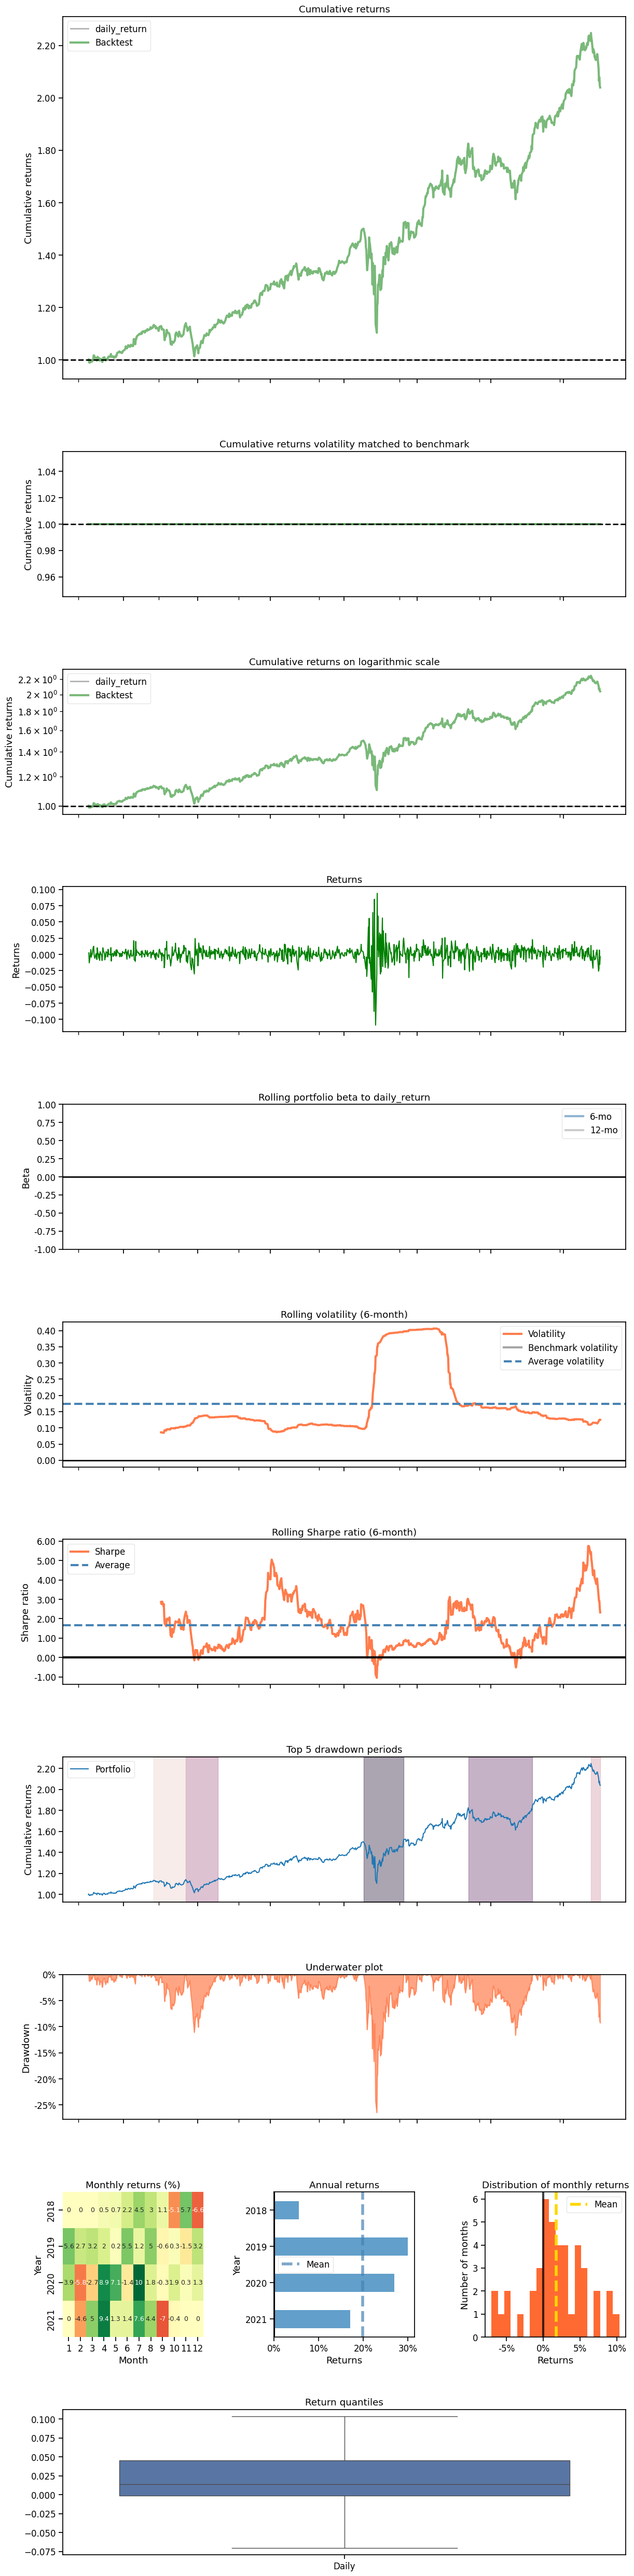

In [155]:
backtest_plot(df_10_mvo)

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (21, 8)


Start date,2018-04-04
End date,2021-10-01
Total months,42
,Backtest
Annual return,22.6%
Cumulative returns,103.8%
Annual volatility,19.2%
Sharpe ratio,1.16
Calmar ratio,0.84
Stability,0.96
Max drawdown,-26.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.84,2020-02-19,2020-03-23,2020-05-29,73
1,11.77,2020-11-06,2021-03-04,2021-04-15,115
2,10.86,2018-12-03,2018-12-24,2019-02-19,57
3,9.28,2021-09-08,2021-10-01,NaT,NaN
4,6.61,2018-09-14,2018-10-29,2018-12-03,57


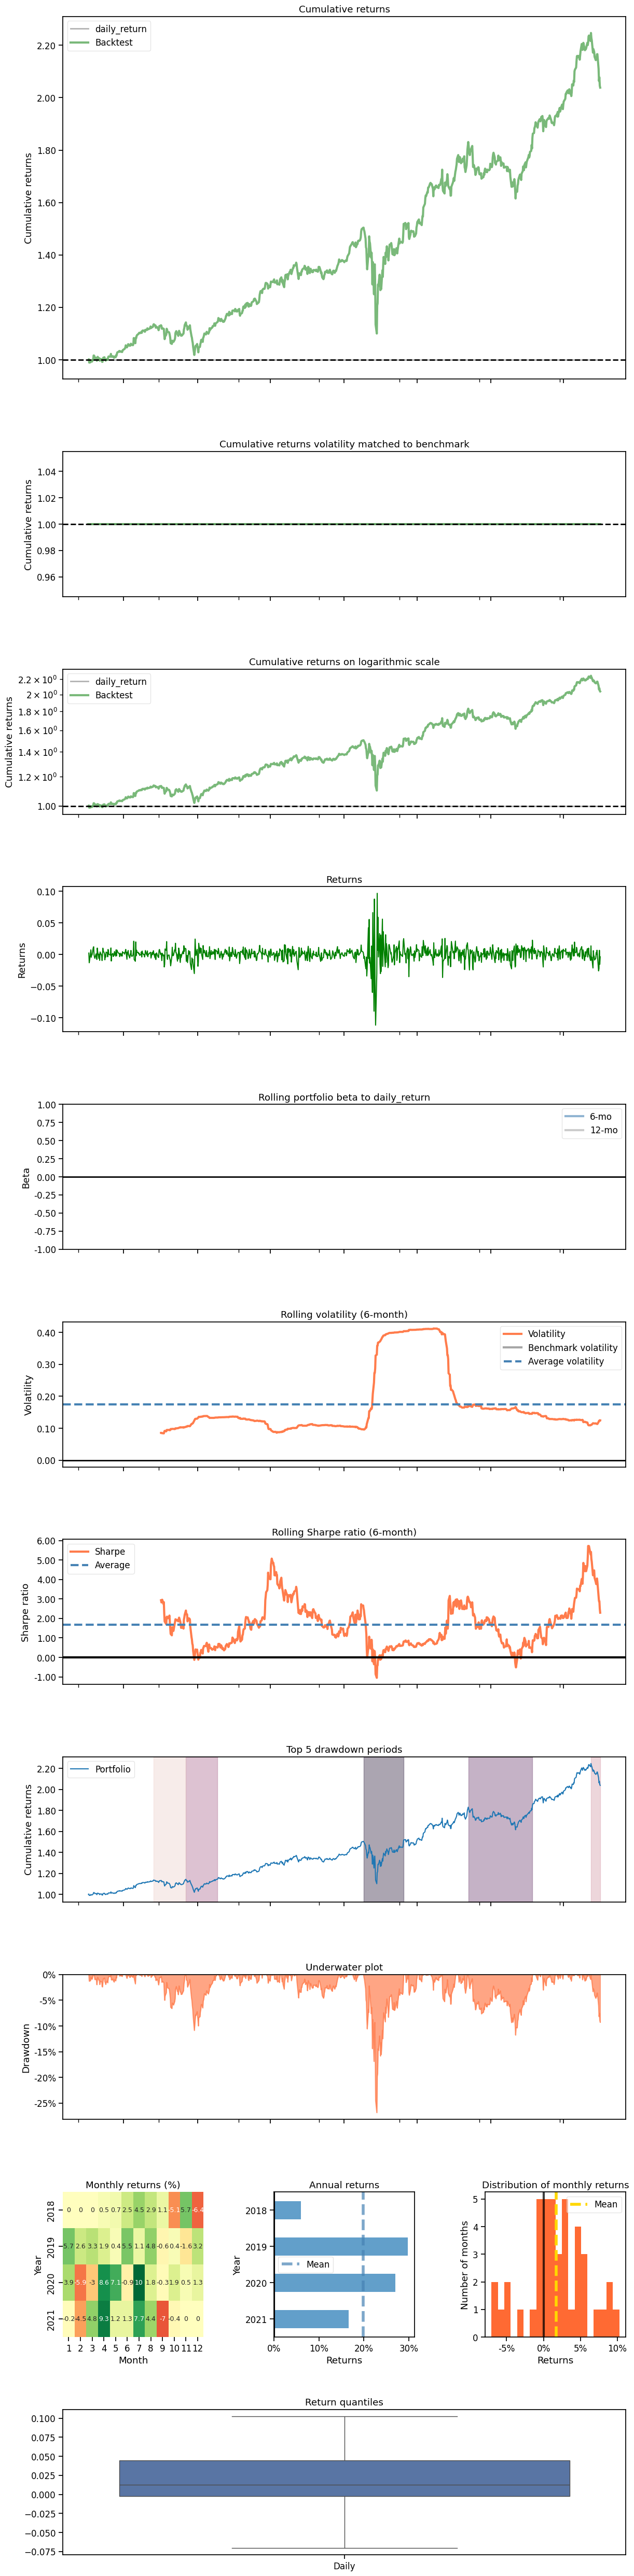

In [158]:
backtest_plot(df_20_mvo)

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (21, 8)


Start date,2018-04-04
End date,2021-10-01
Total months,42
,Backtest
Annual return,23.2%
Cumulative returns,107.5%
Annual volatility,19.6%
Sharpe ratio,1.17
Calmar ratio,0.86
Stability,0.96
Max drawdown,-26.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.89,2020-02-19,2020-03-23,2020-05-29,73
1,11.29,2020-11-06,2021-03-04,2021-04-13,113
2,10.83,2018-12-03,2018-12-24,2019-02-19,57
3,9.22,2021-09-08,2021-10-01,NaT,NaN
4,6.52,2018-09-14,2018-10-29,2018-12-03,57


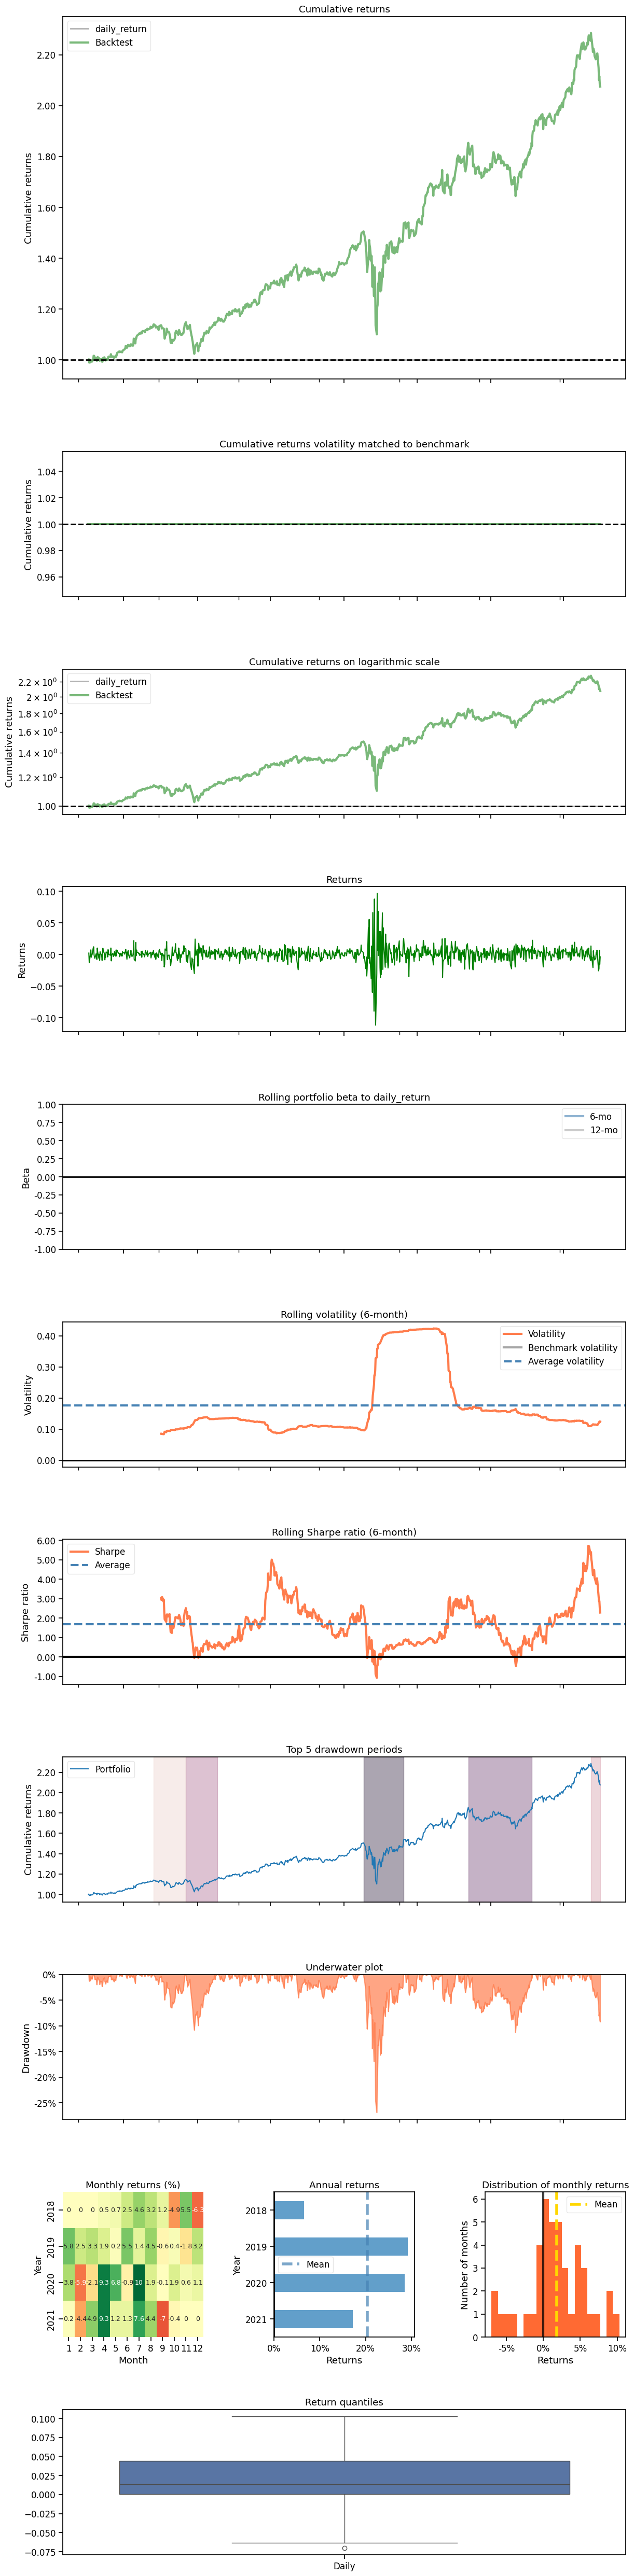

In [159]:
backtest_plot(df_30_mvo)